In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *

### Benchmark Creation
- logic operators: ==, !=, or, and
- arity of 3: a, b, c unique boolean values

In [75]:
SKIP = True
if not SKIP:
    for i in range(len(L)):
        L[i] = L[i].replace('\"', '')
        for key in table:
            L[i] = L[i].replace(key, table[key])

    cfg = CFG(*L)
    primitive_clauses = set([])
    equivalent_clauses = set([])
    for _ in range(10000): # 10000 will get you all the programs.
        clause = generateSentence(cfg)
        if "a == a" in clause or \
            "a != a" in clause or \
            "b == b" in clause or \
            "b != b" in clause or \
            "c == c" in clause or \
            "c != c" in clause:
            continue

        if "and" in clause and \
            clause.split(" and ")[0] == clause.split(" and ")[1]:
            continue
        if "or" in clause and \
            clause.split(" or ")[0] == clause.split(" or ")[1]:
            continue

        if "and" in clause:
            variables = set([])
            for c in clause.split(" and "):
                if "==" in c:
                    for t in c.strip("() ").split(" == "):
                        variables.add(t)
                elif "!=" in c:
                    for t in c.strip("() ").split(" != "):
                        variables.add(t)
            if len(variables) < 3:
                continue

            left = sorted(clause.split(" and ")[0].split())
            right = sorted(clause.split(" and ")[1].split())

            if ("and", tuple(left), tuple(right)) in equivalent_clauses or \
                ("and", tuple(right), tuple(left)) in equivalent_clauses:
                continue
            else:
                equivalent_clauses.add(("and", tuple(left), tuple(right)))
                equivalent_clauses.add(("and", tuple(right), tuple(left)))

        if "or" in clause:
            variables = set([])
            for c in clause.split(" or "):
                if "==" in c:
                    for t in c.strip("() ").split(" == "):
                        variables.add(t)
                elif "!=" in c:
                    for t in c.strip("() ").split(" != "):
                        variables.add(t)
            if len(variables) < 3:
                continue

            left = sorted(clause.split(" or ")[0].split())
            right = sorted(clause.split(" or ")[1].split())
            
            if ("or", tuple(left), tuple(right)) in equivalent_clauses or \
                ("or", tuple(right), tuple(left)) in equivalent_clauses:
                continue
            else:
                equivalent_clauses.add(("or", tuple(left), tuple(right)))
                equivalent_clauses.add(("or", tuple(right), tuple(left)))

        primitive_clauses.add(clause)


    primitive_clauses = list(primitive_clauses)
    random.shuffle(primitive_clauses)
    training_clauses = primitive_clauses[:20]
    eval_clauses = primitive_clauses[20:]
    pickle.dump(primitive_clauses, open("./cfg_all.pkl", 'wb'))
    pickle.dump(training_clauses, open("./cfg_train.pkl", 'wb'))
    pickle.dump(eval_clauses, open("./cfg_test.pkl", 'wb'))
    
else:
    
    primitive_clauses = [
     '( a != c ) and ( a == b )',
     '( c != a ) or ( b != a )',
     '( b != a ) and ( c != a )',
     '( b == a ) or ( c != a )',
     '( a == b ) or ( b == c )',
     '( c == a ) and ( a == b )',
     '( b != a ) and ( b != c )',
     '( b == a ) or ( a == c )',
     '( c == a ) and ( c != b )',
     '( c == b ) and ( c != a )',
     '( c != b ) or ( a == c )',
     '( b != a ) or ( c == a )',
     '( c != b ) and ( c != a )',
     '( a == c ) or ( b == c )',
    ]
    random.shuffle(primitive_clauses)
    training_clauses = primitive_clauses[:11]
    eval_clauses = primitive_clauses[11:]
    pickle.dump(primitive_clauses, open("./cfg_all.pkl", 'wb'))
    pickle.dump(training_clauses, open("./cfg_train.pkl", 'wb'))
    pickle.dump(eval_clauses, open("./cfg_test.pkl", 'wb'))
    

In [59]:
def sample_demonstrations_for_clauses_forward(
    clauses,
    n
):
    value_assignments = []
    for _ in range(n):
        value_assignment = {}
        rotary_index = random.choice([1,2,3])
        if rotary_index == 1:
            #abc
            ab_equal = True if random.random() < 0.5 else False
            bc_equal = True if random.random() < 0.5 else False
            a = sample_var(exclude=[])
            b = a if ab_equal else sample_var(exclude=[a])
            c = b if bc_equal else sample_var(exclude=[b])
        elif rotary_index == 2:
            #bca
            bc_equal = True if random.random() < 0.5 else False
            ca_equal = True if random.random() < 0.5 else False
            b = sample_var(exclude=[])
            c = b if bc_equal else sample_var(exclude=[b])
            a = c if ca_equal else sample_var(exclude=[c])
        elif rotary_index == 3:
            #cab
            ca_equal = True if random.random() < 0.5 else False
            ab_equal = True if random.random() < 0.5 else False
            c = sample_var(exclude=[])
            a = c if ca_equal else sample_var(exclude=[c])
            b = a if ab_equal else sample_var(exclude=[a])                                                                                                                                 
        value_assignment['a'] = a
        value_assignment['b'] = b
        value_assignment['c'] = c
        
        conjs = re.split(r"\s*(?:and|or)\s*", clauses)
        left_args = re.split(r"\s*(?:!=|==)\s*", conjs[0])
        right_args = re.split(r"\s*(?:!=|==)\s*", conjs[1])
        if "!=" in conjs[0]:
            LEFT_VAL = value_assignment[left_args[0].strip(" (")] != value_assignment[left_args[1].strip(" )")]
        elif "==" in conjs[0]:
            LEFT_VAL = value_assignment[left_args[0].strip(" (")] == value_assignment[left_args[1].strip(" )")]
        if "!=" in conjs[1]:
            RIGHT_VAL = value_assignment[right_args[0].strip(" (")] != value_assignment[right_args[1].strip(" )")]
        elif "==" in conjs[1]:
            RIGHT_VAL = value_assignment[right_args[0].strip(" (")] == value_assignment[right_args[1].strip(" )")]
        value_assignment["LEFT_EQ"] = conjs[0]
        value_assignment["RIGHT_EQ"] = conjs[1]
        if "and" in clauses:
            output = LEFT_VAL and RIGHT_VAL
        elif "or" in clauses:
            output = LEFT_VAL or RIGHT_VAL
        value_assignment["LEFT_VAL"] = LEFT_VAL
        value_assignment["RIGHT_VAL"] = RIGHT_VAL
        value_assignment['output'] = output
        value_assignment['clause'] = clauses

        value_assignments += [value_assignment]
        # print(value_assignment)
    return value_assignments


In [83]:
training_clauses

['( c == a ) and ( c != b )',
 '( a == b ) or ( b == c )',
 '( b != a ) or ( c == a )']

In [88]:
n_training_examples = 100000
n_eval_examples = 1000
n_test_examples = 1000
n_training_program = 7
n_fewshot = 6

seed = 42
set_seed(seed)
#################
#
# DO NOT CHANGE
#
#################
n_examples = n_fewshot + 1
training_clauses = pickle.load(open("./cfg_train.pkl", 'rb'))
eval_clauses = pickle.load(open("./cfg_test.pkl", 'rb'))
if n_training_program is not None:
    training_clauses = random.sample(training_clauses, k=n_training_program)
    
all_train_input_ids = []
all_train_output_ids = []
all_train_clauses = []
m = {}
for c in training_clauses:
    m[c] = [0, 0]
for i in tqdm(range(n_training_examples)):
    clauses = random.choice(training_clauses)
    demostrations = sample_demonstrations_for_clauses_forward(
        clauses,
        n_examples
    )
    
    # print(f"c: {clauses}; a:{demostrations[0]['a']}, b:{demostrations[0]['b']}, c:{demostrations[0]['c']}, o:{demostrations[0]['output']}")
    
    # listify
    input_ids = [BOS_TOKEN_ID]
    output_ids = [BOS_TOKEN_ID]
    for d in demostrations:
        m[clauses][int(d['output'])] += 1
        output = FALSE_TOKEN_ID if d['output'] == False else TRUE_TOKEN_ID
        input_ids += [INPUT_PREFIX_TOKEN_ID, d['a'], d['b'], d['c'], OUTPUT_PREFIX_TOKEN_ID, output, SEPARATOR_TOKEN_ID]
        output_ids += [-100, -100, -100, -100, -100, output, -100]
        assert len(input_ids) == len(output_ids)
    input_ids += [EOS_TOKEN_ID]
    output_ids += [EOS_TOKEN_ID]
    all_train_input_ids += [input_ids]
    all_train_output_ids += [output_ids]
    all_train_clauses += [clauses]
    
all_eval_input_ids = []
all_eval_output_ids = []
all_eval_clauses = []
for i in tqdm(range(n_eval_examples)):
    clauses = random.choice(training_clauses)
    demostrations = sample_demonstrations_for_clauses_forward(
        clauses,
        n_examples
    )
    
    # listify
    input_ids = [BOS_TOKEN_ID]
    output_ids = [BOS_TOKEN_ID]
    for d in demostrations:
        output = FALSE_TOKEN_ID if d['output'] == False else TRUE_TOKEN_ID
        input_ids += [INPUT_PREFIX_TOKEN_ID, d['a'], d['b'], d['c'], OUTPUT_PREFIX_TOKEN_ID, output, SEPARATOR_TOKEN_ID]
        output_ids += [-100, -100, -100, -100, -100, output, -100]
        assert len(input_ids) == len(output_ids)
    input_ids += [EOS_TOKEN_ID]
    output_ids += [EOS_TOKEN_ID]
    all_eval_input_ids += [input_ids]
    all_eval_output_ids += [output_ids]
    all_eval_clauses += [clauses]
    
train_data = {
    "input_ids" : all_train_input_ids,
    "output_ids" : all_train_output_ids,
    "clauses" : all_train_clauses,
}
dev_data = {
    "input_ids" : all_eval_input_ids,
    "output_ids" : all_eval_output_ids,
    "clauses" : all_eval_clauses,
}
pickle.dump(train_data, open(f"./train_data.n_rule.{n_training_program}.n_shot.{n_fewshot}.pkl", 'wb'))
pickle.dump(dev_data, open(f"./dev_data.n_rule.{n_training_program}.n_shot.{n_fewshot}.pkl", 'wb'))

all_test_input_ids = []
all_test_output_ids = []
all_test_clauses = []
for i in tqdm(range(n_test_examples)):
    clauses = random.choice(eval_clauses)
    demostrations = sample_demonstrations_for_clauses_forward(
        clauses,
        n_examples
    )
    
    # listify
    input_ids = [BOS_TOKEN_ID]
    output_ids = [BOS_TOKEN_ID]
    for d in demostrations:
        output = FALSE_TOKEN_ID if d['output'] == False else TRUE_TOKEN_ID
        input_ids += [INPUT_PREFIX_TOKEN_ID, d['a'], d['b'], d['c'], OUTPUT_PREFIX_TOKEN_ID, output, SEPARATOR_TOKEN_ID]
        output_ids += [-100, -100, -100, -100, -100, output, -100]
        assert len(input_ids) == len(output_ids)
    input_ids += [EOS_TOKEN_ID]
    output_ids += [EOS_TOKEN_ID]
    all_test_input_ids += [input_ids]
    all_test_output_ids += [output_ids]
    all_test_clauses += [clauses]
    
test_data = {
    "input_ids" : all_test_input_ids,
    "output_ids" : all_test_output_ids,
    "clauses" : all_test_clauses,
}
pickle.dump(test_data, open(f"./test_data.n_rule.{n_training_program}.n_shot.{n_fewshot}.pkl", 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 12420.17it/s]


## Bayesian Rule Inference

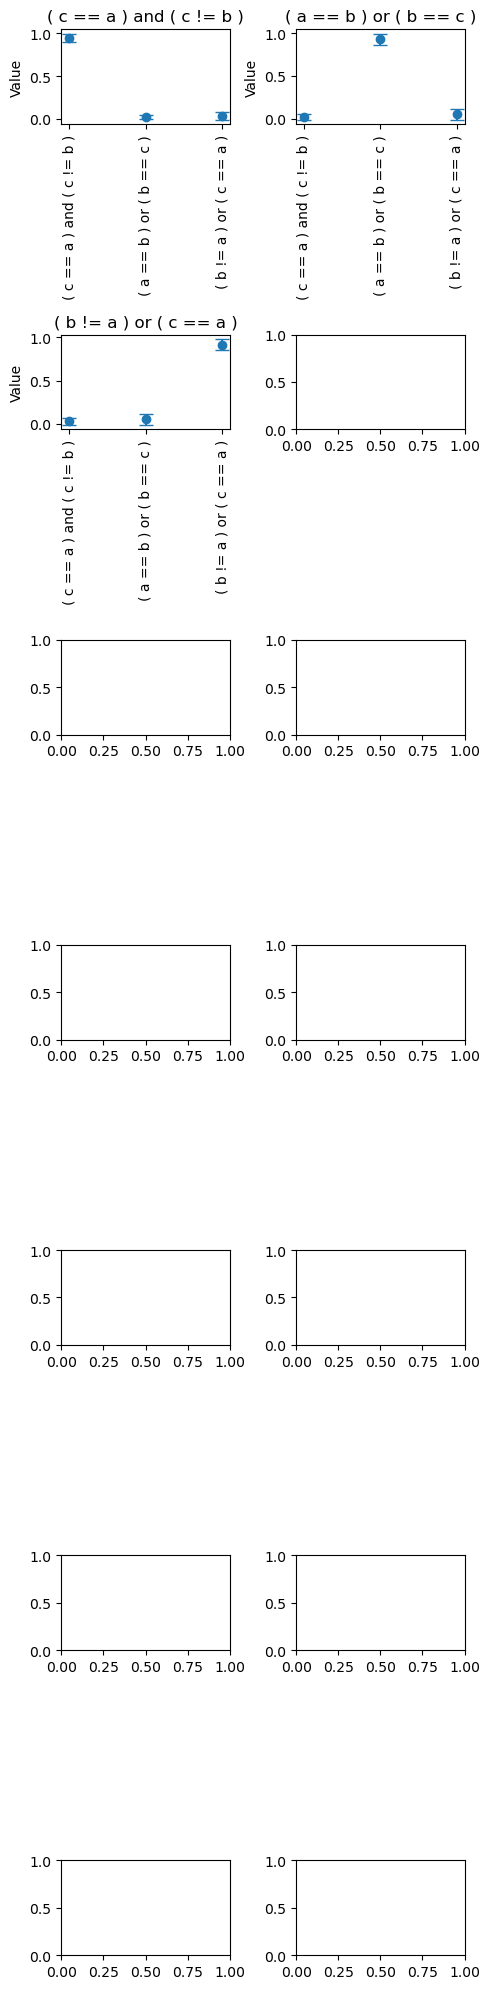

In [82]:
def _eval(
    clauses,
    assignments
):
    eval_clauses = clauses.replace('a ', str(assignments['a']))
    eval_clauses = eval_clauses.replace('b ', str(assignments['b']))
    eval_clauses= eval_clauses.replace('c ', str(assignments['c']))
    return eval(eval_clauses)


n_shots = 6
n_experiment = 1000
fig, axs = plt.subplots(7, 2, figsize=(5, 20))

rule_idx = 0
for hidden_rule in training_clauses:

    experiment_results = []
    for _ in range(n_experiment):
        prior_hit_count = [0 for _ in training_clauses]
        for i in range(n_shots):
            data = sample_demonstrations_for_clauses_forward(
                hidden_rule,
                1
            )[0]
            idx = 0
            for clauses in training_clauses:
                eval_output = _eval(clauses, data)
                if eval_output == data['output']:
                    prior_hit_count[idx] += 1
                idx += 1
        prior_hit_count = np.array(prior_hit_count)
        prior_hit_count = np.exp(prior_hit_count) / np.sum(np.exp(prior_hit_count))
        experiment_results += [prior_hit_count]

    # Convert the 2D list to a NumPy array
    data = np.array(experiment_results)
    # Calculate the mean and standard deviation of each column
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    # Set up the plot
    
    # Plot the mean and standard deviation as error bars
    axs[rule_idx//2, rule_idx%2].errorbar(range(data.shape[1]), mean, yerr=std, fmt='o', capsize=5)
    # Set the x-axis labels
    axs[rule_idx//2, rule_idx%2].set_xticks(range(data.shape[1]))
    axs[rule_idx//2, rule_idx%2].set_xticklabels([training_clauses[i] for i in range(data.shape[1])], rotation=90)
    # Set the y-axis label
    axs[rule_idx//2, rule_idx%2].set_ylabel('Value')
    # Set the title
    axs[rule_idx//2, rule_idx%2].set_title(f'{hidden_rule}')
    
    rule_idx += 1
    
# Show the plot
fig.tight_layout()
plt.show()

## L1
for each rule, we want to have at least one good model and one bad model, and we need to compare accuracies between them!

'( a == b ) or ( b == c )',

'( a == c ) or ( b == c )',

'( b != a ) or ( c == a )',

'( b == a ) or ( a == c )',

'( c == a ) and ( a == b )',

'( c == a ) and ( c != b )',

'( c == b ) and ( c != a )'

In [ ]:
# clauses = "( c == a ) or ( b != a )"
# clauses = "( c == a ) and ( a == b )"
# crazy zero-shot
# clauses = "( c != a ) and ( c == b )"
clauses = "( c == a ) or ( c == b )"

n_training_examples = 20000
shared_train = True
n_fewshot = 14

n_examples = n_fewshot + 1
left_aligment_data = left_aligment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
)
left_identity_alignment_data = left_identity_alignment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
)

left_aligment_train_data = {
    "base_input_ids" : left_aligment_data[0],
    "base_output_ids" : left_aligment_data[1],
    "source_input_ids" : left_aligment_data[3],
    "source_output_ids" : left_aligment_data[4],
    "counterfacut_output_ids": left_aligment_data[6],
    "clauses" : left_aligment_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_train_data, open(f"./left_aligment_train_data.l1.clauses.{clauses_no_space}.pkl", 'wb'))

left_identity_alignment_train_data = {
    "base_input_ids" : left_identity_alignment_data[0],
    "base_output_ids" : left_identity_alignment_data[1],
    "source_input_ids" : left_identity_alignment_data[3],
    "source_output_ids" : left_identity_alignment_data[4],
    "counterfacut_output_ids": left_identity_alignment_data[6],
    "clauses" : left_identity_alignment_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_train_data, open(f"./left_identity_alignment_train_data.l1.clauses.{clauses_no_space}.pkl", 'wb'))

n_testing_examples = 1000
left_aligment_sampled_data = left_aligment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
)
left_identity_alignment_sampled_data = left_identity_alignment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
)

left_aligment_test_data = {
    "base_input_ids" : left_aligment_sampled_data[0],
    "base_output_ids" : left_aligment_sampled_data[1],
    "source_input_ids" : left_aligment_sampled_data[3],
    "source_output_ids" : left_aligment_sampled_data[4],
    "counterfacut_output_ids": left_aligment_sampled_data[6],
    "clauses" : left_aligment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_test_data, open(f"./left_aligment_test_data.l1.clauses.{clauses_no_space}.pkl", 'wb'))

left_identity_alignment_test_data = {
    "base_input_ids" : left_identity_alignment_sampled_data[0],
    "base_output_ids" : left_identity_alignment_sampled_data[1],
    "source_input_ids" : left_identity_alignment_sampled_data[3],
    "source_output_ids" : left_identity_alignment_sampled_data[4],
    "counterfacut_output_ids": left_identity_alignment_sampled_data[6],
    "clauses" : left_identity_alignment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_test_data, open(f"./left_identity_alignment_test_data.l1.clauses.{clauses_no_space}.pkl", 'wb'))

## L2

In [ ]:
clauses = "( c == a ) and ( a == b )"
# clauses = "( c == a ) and ( a == b )"
n_training_examples = 20000
shared_train = False

left_aligment_data = left_aligment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
)
left_identity_alignment_data = left_identity_alignment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
)

left_aligment_train_data = {
    "base_input_ids" : left_aligment_data[0],
    "base_output_ids" : left_aligment_data[1],
    "source_input_ids" : left_aligment_data[3],
    "source_output_ids" : left_aligment_data[4],
    "counterfacut_output_ids": left_aligment_data[6],
    "clauses" : left_aligment_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_train_data, open(f"./left_aligment_train_data.l2.clauses.{clauses_no_space}.pkl", 'wb'))

left_identity_alignment_train_data = {
    "base_input_ids" : left_identity_alignment_data[0],
    "base_output_ids" : left_identity_alignment_data[1],
    "source_input_ids" : left_identity_alignment_data[3],
    "source_output_ids" : left_identity_alignment_data[4],
    "counterfacut_output_ids": left_identity_alignment_data[6],
    "clauses" : left_identity_alignment_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_train_data, open(f"./left_identity_alignment_train_data.l2.clauses.{clauses_no_space}.pkl", 'wb'))

n_testing_examples = 1000
left_aligment_sampled_data = left_aligment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
)
left_identity_alignment_sampled_data = left_identity_alignment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
)

left_aligment_test_data = {
    "base_input_ids" : left_aligment_sampled_data[0],
    "base_output_ids" : left_aligment_sampled_data[1],
    "source_input_ids" : left_aligment_sampled_data[3],
    "source_output_ids" : left_aligment_sampled_data[4],
    "counterfacut_output_ids": left_aligment_sampled_data[6],
    "clauses" : left_aligment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_test_data, open(f"./left_aligment_test_data.l2.clauses.{clauses_no_space}.pkl", 'wb'))

left_identity_alignment_test_data = {
    "base_input_ids" : left_identity_alignment_sampled_data[0],
    "base_output_ids" : left_identity_alignment_sampled_data[1],
    "source_input_ids" : left_identity_alignment_sampled_data[3],
    "source_output_ids" : left_identity_alignment_sampled_data[4],
    "counterfacut_output_ids": left_identity_alignment_sampled_data[6],
    "clauses" : left_identity_alignment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_test_data, open(f"./left_identity_alignment_test_data.l2.clauses.{clauses_no_space}.pkl", 'wb'))

## L3

In [ ]:
clauses = "( c == a ) or ( b != a )"
source_clauses = "( c == a ) and ( a == b )"
n_training_examples = 20000
shared_train = False

left_aligment_data = left_aligment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train, source_clauses=source_clauses
)
left_identity_alignment_data = left_identity_alignment_sampler(
    clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train, source_clauses=source_clauses
)

left_aligment_train_data = {
    "base_input_ids" : left_aligment_data[0],
    "base_output_ids" : left_aligment_data[1],
    "source_input_ids" : left_aligment_data[3],
    "source_output_ids" : left_aligment_data[4],
    "counterfacut_output_ids": left_aligment_data[6],
    "clauses" : left_aligment_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
source_clauses_no_space = source_clauses.replace(" ", "")
pickle.dump(left_aligment_train_data, open(f"./left_aligment_train_data.l3.clauses.{clauses_no_space}+{source_clauses_no_space}.pkl", 'wb'))

left_identity_alignment_train_data = {
    "base_input_ids" : left_identity_alignment_data[0],
    "base_output_ids" : left_identity_alignment_data[1],
    "source_input_ids" : left_identity_alignment_data[3],
    "source_output_ids" : left_identity_alignment_data[4],
    "counterfacut_output_ids": left_identity_alignment_data[6],
    "clauses" : left_identity_alignment_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_train_data, open(f"./left_identity_alignment_train_data.l3.clauses.{clauses_no_space}+{source_clauses_no_space}.pkl", 'wb'))

n_testing_examples = 1000
left_aligment_sampled_data = left_aligment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train, source_clauses=source_clauses
)
left_identity_alignment_sampled_data = left_identity_alignment_sampler(
    clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train, source_clauses=source_clauses
)

left_aligment_test_data = {
    "base_input_ids" : left_aligment_sampled_data[0],
    "base_output_ids" : left_aligment_sampled_data[1],
    "source_input_ids" : left_aligment_sampled_data[3],
    "source_output_ids" : left_aligment_sampled_data[4],
    "counterfacut_output_ids": left_aligment_sampled_data[6],
    "clauses" : left_aligment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_aligment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_test_data, open(f"./left_aligment_test_data.l3.clauses.{clauses_no_space}+{source_clauses_no_space}.pkl", 'wb'))

left_identity_alignment_test_data = {
    "base_input_ids" : left_identity_alignment_sampled_data[0],
    "base_output_ids" : left_identity_alignment_sampled_data[1],
    "source_input_ids" : left_identity_alignment_sampled_data[3],
    "source_output_ids" : left_identity_alignment_sampled_data[4],
    "counterfacut_output_ids": left_identity_alignment_sampled_data[6],
    "clauses" : left_identity_alignment_sampled_data[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_sampled_data[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_test_data, open(f"./left_identity_alignment_test_data.l3.clauses.{clauses_no_space}+{source_clauses_no_space}.pkl", 'wb'))

## L3+ (L3 Exchange)

In [ ]:
clauses = "( a != b ) and ( c == b )"
source_clauses = "( a != b ) or ( c == a )"
n_training_examples = 20000
shared_train = False

left_aligment_data = left_aligment_sampler(
    clauses, n_training_examples, shared_train=shared_train, source_clauses=source_clauses
)
left_identity_alignment_data = left_identity_alignment_sampler(
    clauses, n_training_examples, shared_train=shared_train, source_clauses=source_clauses
)

left_aligment_data_exchange = left_aligment_sampler(
    source_clauses, n_training_examples, shared_train=shared_train, source_clauses=clauses
)
left_identity_alignment_data_exchange = left_identity_alignment_sampler(
    source_clauses, n_training_examples, shared_train=shared_train, source_clauses=clauses
)

left_aligment_train_data = {
    "base_input_ids" : left_aligment_data[0]+left_aligment_data_exchange[0],
    "base_output_ids" : left_aligment_data[1]+left_aligment_data_exchange[1],
    "source_input_ids" : left_aligment_data[3]+left_aligment_data_exchange[3],
    "source_output_ids" : left_aligment_data[4]+left_aligment_data_exchange[4],
    "counterfacut_output_ids": left_aligment_data[6]+left_aligment_data_exchange[6],
    "clauses" : left_aligment_data[2]+left_aligment_data_exchange[2],
    "intervention_ids": [0 for i in range(len(left_aligment_data[0]+left_aligment_data_exchange[0]))]
}
clauses_no_space = clauses.replace(" ", "")
source_clauses_no_space = source_clauses.replace(" ", "")
pickle.dump(left_aligment_train_data, open(f"./left_aligment_train_data.l3.clauses.{clauses_no_space}<>{source_clauses_no_space}.pkl", 'wb'))

left_identity_alignment_train_data = {
    "base_input_ids" : left_identity_alignment_data[0]+left_identity_alignment_data_exchange[0],
    "base_output_ids" : left_identity_alignment_data[1]+left_identity_alignment_data_exchange[1],
    "source_input_ids" : left_identity_alignment_data[3]+left_identity_alignment_data_exchange[3],
    "source_output_ids" : left_identity_alignment_data[4]+left_identity_alignment_data_exchange[4],
    "counterfacut_output_ids": left_identity_alignment_data[6]+left_identity_alignment_data_exchange[6],
    "clauses" : left_identity_alignment_data[2]+left_identity_alignment_data_exchange[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_data[0]+left_identity_alignment_data_exchange[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_train_data, open(f"./left_identity_alignment_train_data.l3.clauses.{clauses_no_space}<>{source_clauses_no_space}.pkl", 'wb'))

n_testing_examples = 1000
left_aligment_sampled_data = left_aligment_sampler(
    clauses, n_testing_examples, shared_train=shared_train, source_clauses=source_clauses
)
left_identity_alignment_sampled_data = left_identity_alignment_sampler(
    clauses, n_testing_examples, shared_train=shared_train, source_clauses=source_clauses
)

left_aligment_sampled_data_exchange = left_aligment_sampler(
    source_clauses, n_training_examples, shared_train=shared_train, source_clauses=clauses
)
left_identity_alignment_sampled_data_exchange = left_identity_alignment_sampler(
    source_clauses, n_training_examples, shared_train=shared_train, source_clauses=clauses
)

left_aligment_test_data = {
    "base_input_ids" : left_aligment_sampled_data[0]+left_aligment_sampled_data_exchange[0],
    "base_output_ids" : left_aligment_sampled_data[1]+left_aligment_sampled_data_exchange[1],
    "source_input_ids" : left_aligment_sampled_data[3]+left_aligment_sampled_data_exchange[3],
    "source_output_ids" : left_aligment_sampled_data[4]+left_aligment_sampled_data_exchange[4],
    "counterfacut_output_ids": left_aligment_sampled_data[6]+left_aligment_sampled_data_exchange[6],
    "clauses" : left_aligment_sampled_data[2]+left_aligment_sampled_data_exchange[2],
    "intervention_ids": [0 for i in range(len(left_aligment_sampled_data[0]+left_aligment_sampled_data_exchange[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_aligment_test_data, open(f"./left_aligment_test_data.l3.clauses.{clauses_no_space}<>{source_clauses_no_space}.pkl", 'wb'))

left_identity_alignment_test_data = {
    "base_input_ids" : left_identity_alignment_sampled_data[0]+left_identity_alignment_sampled_data_exchange[0],
    "base_output_ids" : left_identity_alignment_sampled_data[1]+left_identity_alignment_sampled_data_exchange[1],
    "source_input_ids" : left_identity_alignment_sampled_data[3]+left_identity_alignment_sampled_data_exchange[3],
    "source_output_ids" : left_identity_alignment_sampled_data[4]+left_identity_alignment_sampled_data_exchange[4],
    "counterfacut_output_ids": left_identity_alignment_sampled_data[6]+left_identity_alignment_sampled_data_exchange[6],
    "clauses" : left_identity_alignment_sampled_data[2]+left_identity_alignment_sampled_data_exchange[2],
    "intervention_ids": [0 for i in range(len(left_identity_alignment_sampled_data[0]+left_identity_alignment_sampled_data_exchange[0]))]
}
clauses_no_space = clauses.replace(" ", "")
pickle.dump(left_identity_alignment_test_data, open(f"./left_identity_alignment_test_data.l3.clauses.{clauses_no_space}<>{source_clauses_no_space}.pkl", 'wb'))

## L1 Unrolling

In [ ]:
clauses = "( c == b ) and ( c != a )"
# clauses = "( a != b ) and ( c == b )"
n_training_examples = 20000
shared_train = False
for n_examples in range(1, 8):

#     left_aligment_data = left_aligment_sampler(
#         clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
#     )
#     left_identity_alignment_data = left_identity_alignment_sampler(
#         clauses, n_training_examples, n_examples = n_examples, shared_train=shared_train
#     )

#     left_aligment_train_data = {
#         "base_input_ids" : left_aligment_data[0],
#         "base_output_ids" : left_aligment_data[1],
#         "source_input_ids" : left_aligment_data[3],
#         "source_output_ids" : left_aligment_data[4],
#         "counterfacut_output_ids": left_aligment_data[6],
#         "clauses" : left_aligment_data[2],
#         "intervention_ids": [0 for i in range(len(left_aligment_data[0]))]
#     }
#     clauses_no_space = clauses.replace(" ", "")
#     pickle.dump(left_aligment_train_data, open(f"./left_aligment_train_data.l1.unrolling.{n_examples-1}.clauses.{clauses_no_space}.pkl", 'wb'))

#     left_identity_alignment_train_data = {
#         "base_input_ids" : left_identity_alignment_data[0],
#         "base_output_ids" : left_identity_alignment_data[1],
#         "source_input_ids" : left_identity_alignment_data[3],
#         "source_output_ids" : left_identity_alignment_data[4],
#         "counterfacut_output_ids": left_identity_alignment_data[6],
#         "clauses" : left_identity_alignment_data[2],
#         "intervention_ids": [0 for i in range(len(left_identity_alignment_data[0]))]
#     }
#     clauses_no_space = clauses.replace(" ", "")
#     pickle.dump(left_identity_alignment_train_data, open(f"./left_identity_alignment_train_data.l1.unrolling.{n_examples-1}.clauses.{clauses_no_space}.pkl", 'wb'))

    n_testing_examples = 1000
    left_aligment_sampled_data = left_aligment_sampler(
        clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
    )
    left_identity_alignment_sampled_data = left_identity_alignment_sampler(
        clauses, n_testing_examples, n_examples = n_examples, shared_train=shared_train
    )

    left_aligment_test_data = {
        "base_input_ids" : left_aligment_sampled_data[0],
        "base_output_ids" : left_aligment_sampled_data[1],
        "source_input_ids" : left_aligment_sampled_data[3],
        "source_output_ids" : left_aligment_sampled_data[4],
        "counterfacut_output_ids": left_aligment_sampled_data[6],
        "clauses" : left_aligment_sampled_data[2],
        "intervention_ids": [0 for i in range(len(left_aligment_sampled_data[0]))]
    }
    clauses_no_space = clauses.replace(" ", "")
    pickle.dump(left_aligment_test_data, open(f"./left_aligment_test_data.l1.unrolling.{n_examples-1}.clauses.{clauses_no_space}.pkl", 'wb'))

    left_identity_alignment_test_data = {
        "base_input_ids" : left_identity_alignment_sampled_data[0],
        "base_output_ids" : left_identity_alignment_sampled_data[1],
        "source_input_ids" : left_identity_alignment_sampled_data[3],
        "source_output_ids" : left_identity_alignment_sampled_data[4],
        "counterfacut_output_ids": left_identity_alignment_sampled_data[6],
        "clauses" : left_identity_alignment_sampled_data[2],
        "intervention_ids": [0 for i in range(len(left_identity_alignment_sampled_data[0]))]
    }
    clauses_no_space = clauses.replace(" ", "")
    pickle.dump(left_identity_alignment_test_data, open(f"./left_identity_alignment_test_data.l1.unrolling.{n_examples-1}.clauses.{clauses_no_space}.pkl", 'wb'))

### Some helper functions

In [ ]:
data = pickle.load(open('./dev_data.n_rule.7.n_shot.14.pkl', 'rb'))

In [ ]:
set(data['clauses'])